In [1]:
from Detector import Detector
import plotly.graph_objects as go
from Particle import Particle
from GEANT5 import GEANT5
import numpy as np
import copy

# Create detector
detector = Detector()
GEANT5 = GEANT5()

# Print detector information
print(detector.get_detector_info())

Detector Configuration:
Number of modules: 40
Total length: 5560.0 mm
Plane dimensions: 4191.0 x 4839.3 mm
Module spacing: 20.0 mm
Module gap: 40.0 mm

Module structure:
- X plane
- U plane (+60°)
- X plane
- V plane (-60°)


22.801725957027354
Muon momentum: mean = 237.13 MeV/c, std = 57.54 MeV/c
Muon energy: mean = 260.71 MeV, std = 52.30 MeV
Muon angle x: mean = 90.06°, std = 4.46°
Muon angle y: mean = 90.00°, std = 4.49°
Muon angle z: mean = 5.95°, std = 2.18°


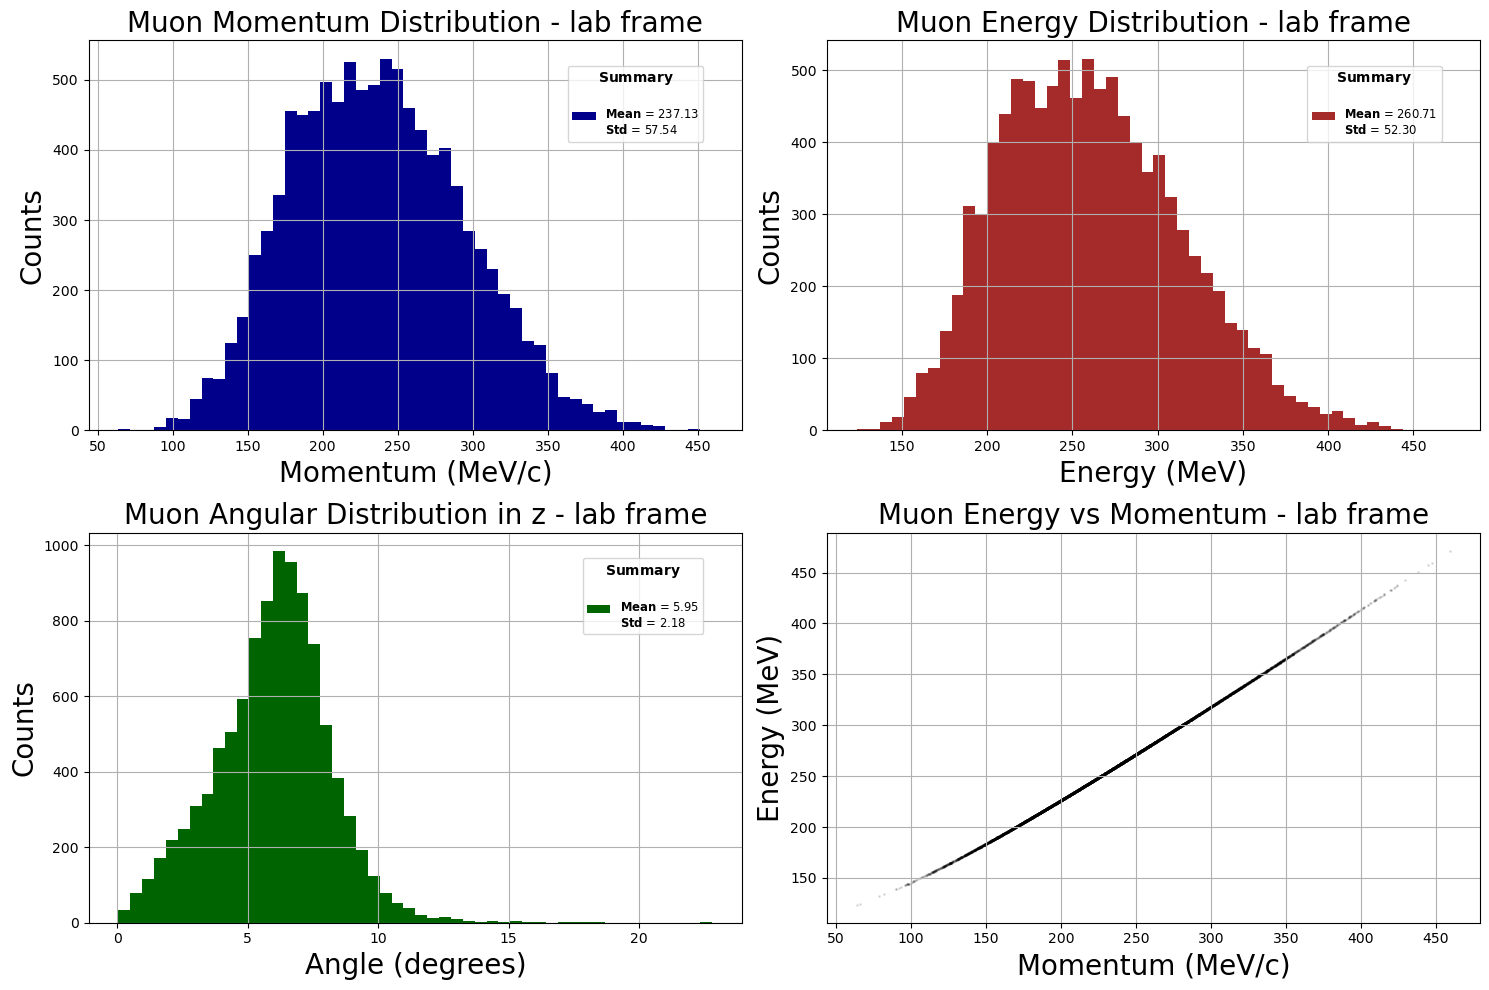

Total tracks: 10000
Contained tracks: 9948
Uncontained tracks: 52


In [10]:
# Generating muons from pion decay
from PionDecaySim import PionDecaySim
decay = PionDecaySim(10000, 300.0, 50.0)
pions = decay.pion_decay_lab_frame()
muon_momentum_rest, nu_momentum_rest = decay.after_decay_particles_rest_frame()
muon_hits = []
CSDA_array, reco_p_array, reco_KE_array = [], [], []
truth_p_array, truth_KE_array = [], []
contained = 0
uncontained_hits_array = []
muons = []
track_linear_reg, track_simple = [], []
initial_energy_array = []

# Simulate muons traveling through scintillator detector
for i in range(decay.n_particles):
    muon = decay.after_decay_particles_lab_frame(muon_momentum_rest[i], 
                                 decay.MUON_MASS, 
                                 pions[i])
    muons.append(copy.deepcopy(muon))
    nu = decay.after_decay_particles_lab_frame(nu_momentum_rest[i],
                               0,
                               pions[i])
    muon.position = np.array([0, 0, -1000])
    truth_p, truth_KE = muon.momentum, muon.energy - muon.mass
    initial_energy = muon.energy
    
    hit_result = GEANT5.track_muon(detector, muon)
    
    if hit_result and hit_result[-1]["contained"] == False: uncontained_hits_array.append(hit_result)
    
    hits = []
    for hit in hit_result:
        hits.append(hit["hit_position"])
    
    theta_array = []
    
    # track reconstruction from hits, this only works for contained particles
    if hit_result and len(hit_result) >= 2 and hit_result[-1]["contained"] == True: # Use only contained tracks
        
        contained += 1
        muon_hits.append(hit_result)
        initial_energy_array.append(initial_energy)

        start = hit_result[0]['hit_position']
        final = hit_result[-1]['hit_position']
        last_module = hit_result[-1]['module']
        last_interplane_dist = 0
        if hit_result[-1]['plane_orientation'] == 'V':
            last_interplane_dist = 3*20
        elif hit_result[-1]['plane_orientation'] == 'U':
            last_interplane_dist = 1*20
        elif len(hit_result) >= 2 and hit_result[-2]['module'] == last_module and hit_result[-1]['plane_orientation'] == 'X':
            last_interplane_dist = 2*20

        track_length_simple = np.linalg.norm(final-start) - hit_result[-1]['module']*40 - 60*hit_result[-1]['module'] - last_interplane_dist + 10
        track_simple.append(track_length_simple)
        track_length = GEANT5.linear_fit(hits) - hit_result[-1]['module']*40 - 60*hit_result[-1]['module'] - last_interplane_dist + 10
        track_linear_reg.append(track_length)
        density = 1.043 

        CSDA = density*track_length/10
        CSDA_array.append(density*track_length/10)
        reco_p, reco_KE = GEANT5.get_kinematics_from_csda(CSDA)
        reco_p_array.append(reco_p)
        reco_KE_array.append(reco_KE)
        truth_p_array.append(np.linalg.norm(truth_p))
        truth_KE_array.append(truth_KE)
    
    # Momentum reconstruction from hits, this should work for both contained and uncontained particles
    if hit_result and len(hit_result) >= 3 and hit_result[-1]["contained"] == True:
        for i in range(0,len(hit_result)-3,1):
            pos1 = hit_result[i+0]["hit_position"]
            pos2 = hit_result[i+1]["hit_position"]
            pos3 = hit_result[i+2]["hit_position"]
            v1 = (pos2 - pos1)/np.linalg.norm(pos2 - pos1)
            v2 = (pos3 - pos2)/np.linalg.norm(pos3 - pos2)
            dot_product = np.dot(v1, v2)
            cross_product = np.cross(v1, v2)
            v1_mag = np.linalg.norm(v1)
            v2_mag = np.linalg.norm(v2)
            cos_theta = dot_product/(v1_mag*v2_mag)
            theta = np.arccos(cos_theta)*180/np.pi
            theta_array.append(theta)
        
truth_p_array = np.array(truth_p_array)
truth_KE_array = np.array(truth_KE_array)
reco_p_array = np.array(reco_p_array)
reco_KE_array = np.array(reco_KE_array)
initial_energy_array = np.array(initial_energy_array)

decay.analyze_results(muons)
print(f"Total tracks: {decay.n_particles}")
print(f"Contained tracks: {contained}")
print(f"Uncontained tracks: {decay.n_particles - contained}")

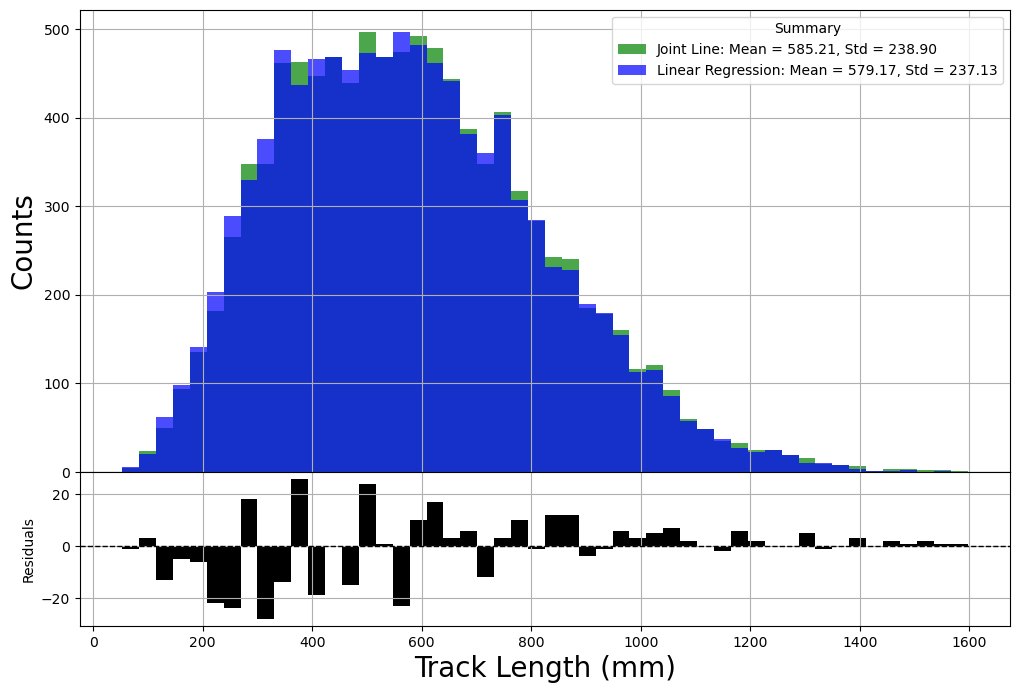

In [11]:
GEANT5.make_histogram_with_residuals(np.array(track_simple), np.array(track_linear_reg), "Track Length (mm)", title1 = "Joint Line", title2 = "Linear Regression", color1 = 'green', color2 = 'blue')

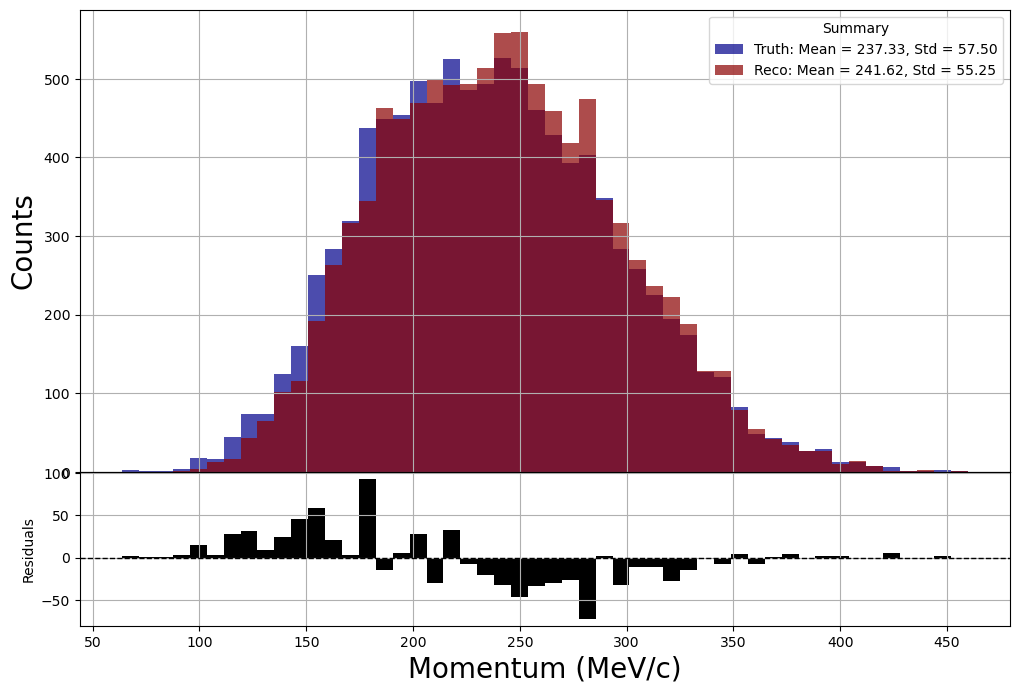

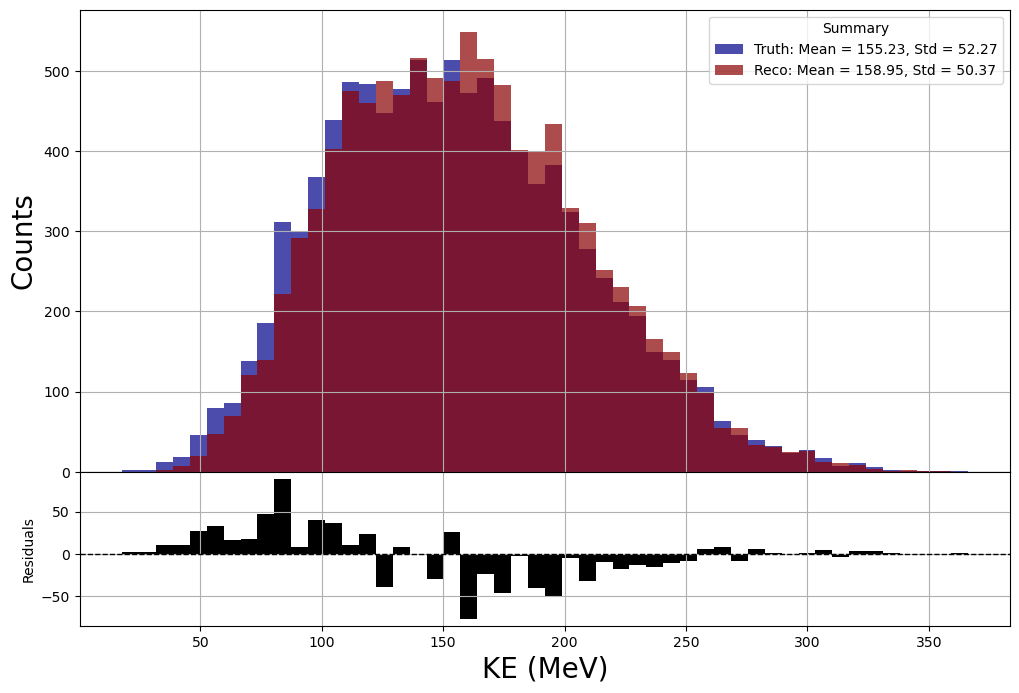

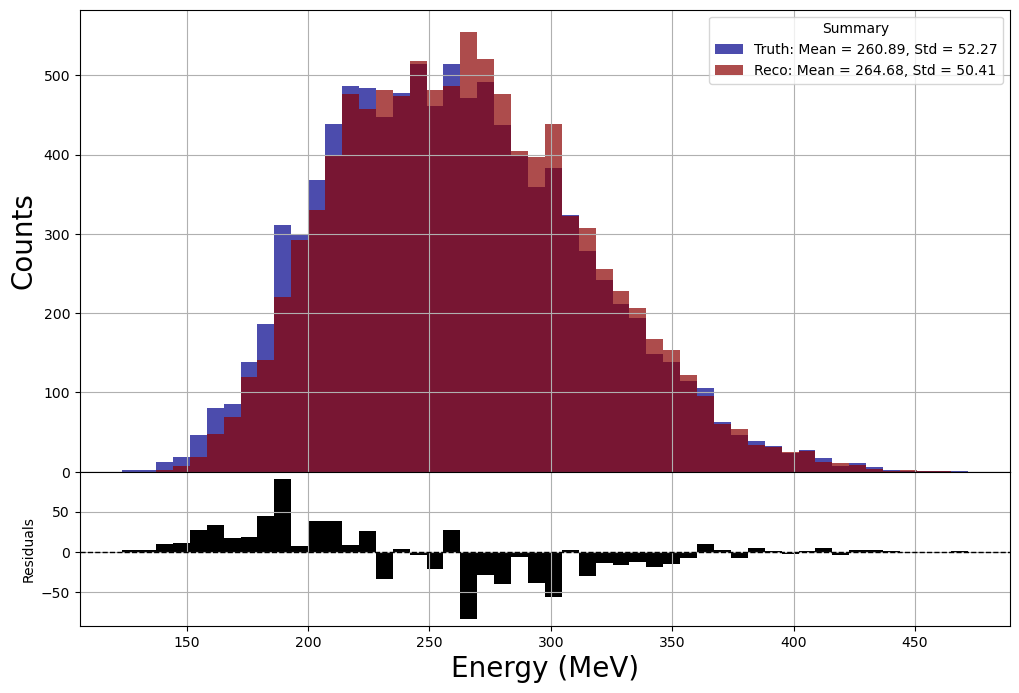

In [12]:
GEANT5.make_histogram_with_residuals(truth_p_array, reco_p_array, "Momentum (MeV/c)")
GEANT5.make_histogram_with_residuals(truth_KE_array, reco_KE_array, "KE (MeV)")
GEANT5.make_histogram_with_residuals(initial_energy_array, np.sqrt(reco_p_array**2 + 105.66**2) , "Energy (MeV)")

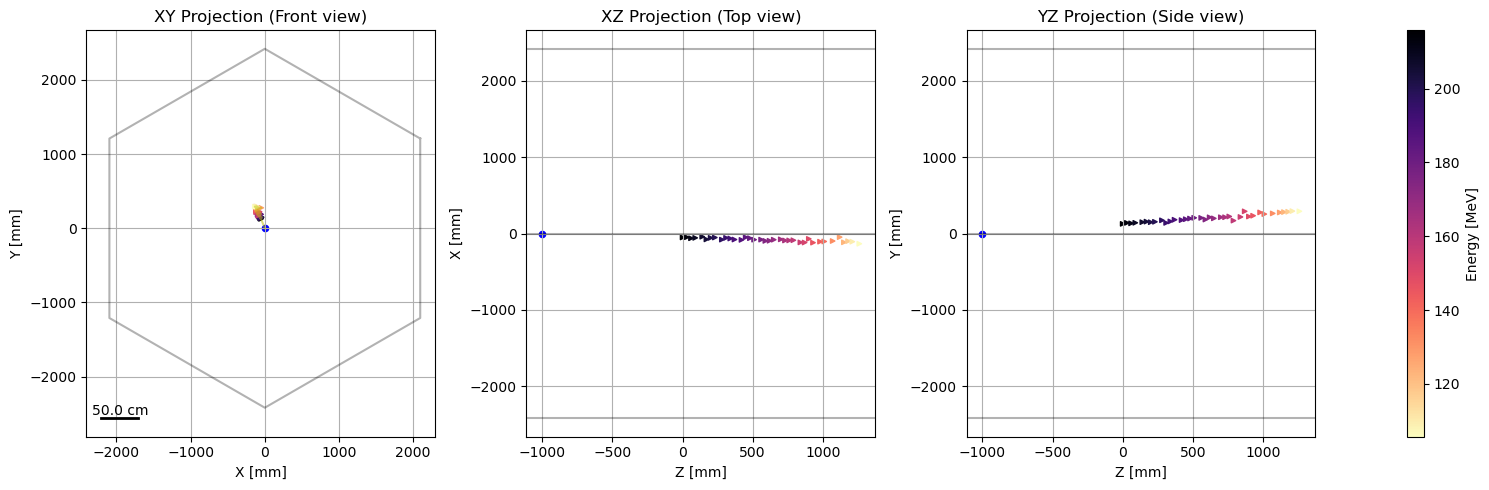

In [13]:
fig = detector.visualize_hits_projections(muon_hits[5])